# Test Presentation
### Vincent Herrmann

# Audio Visualisierungen
- Spektogramm
- Scalogram
- MFCC
- Reassignment

# Short Time Fourier Transform

In [1001]:
import numpy as np
import librosa as lr
from scipy import signal
from librosa import display
from IPython import display
from IPython.display import Audio
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, output_notebook, show, gridplot
import matplotlib
import math
from matplotlib import pyplot as plt

output_notebook()
%matplotlib notebook

Loading BokehJS ...

In [1298]:
voice, sr = lr.core.load('queen.wav', sr=44100)
#voice = voice[0:100000]
#voice = voice*0.
#voice[10240] = 0.8
#voice = np.sin(np.linspace(0,500, 140000)**1.2)
print("sampling rate", sr)
Audio(voice, rate=sr)

sampling rate 44100


<IPython.core.display.Javascript object>


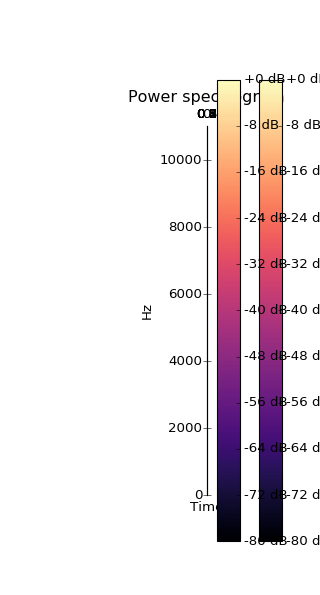

(257, 138)


In [3]:
n_fft = 512
voice_stft = lr.core.stft(voice, n_fft=n_fft)
voice_abs = np.abs(voice_stft)
plt.matshow(voice_abs, 
            origin="lower", 
            aspect=1.0, 
            interpolation="None")
plt.show()
print(voice_abs.shape)

<IPython.core.display.Javascript object>


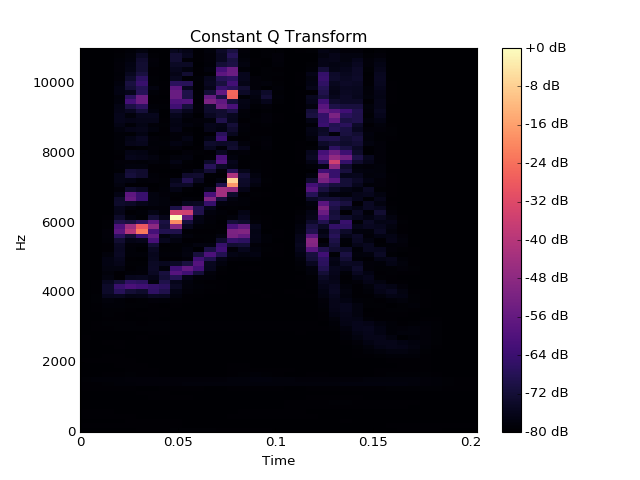

In [10]:
lr.display.specshow(lr.amplitude_to_db(voice_abs,
                                       ref=np.max),
                    y_axis='linear', x_axis='time', hop_length=128, sr=sr)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()
#plt.tight_layout()

In [11]:
def p2r(radii, angles):
    return radii * np.exp(1j*angles)

def r2p(x):
    return np.abs(x), np.angle(x)

zero_phase_voice_stft = p2r(voice_abs, voice_abs*0)
reconstructed_voice = lr.core.istft(zero_phase_voice_stft)
Audio(reconstructed_voice, rate=sr)

In [12]:
noise = np.random.randn(voice.shape[0])
noise_stft = lr.core.stft(noise, n_fft=n_fft)
noisy_phase_voice_stft = p2r(voice_abs, np.angle(noise_stft))
reconstructed_voice = lr.core.istft(noisy_phase_voice_stft)
Audio(reconstructed_voice, rate=sr)

In [13]:
def reconstruct_griffin_lim(stft_abs, hop_length, iterations=100):
    n_fft = int((stft_abs.shape[0]-1) * 2)
    time_slices = stft_abs.shape[1] - 1
    len_samples = int(time_slices*hop_length)
    reconstructed_signal = np.random.randn(len_samples)
    for i in range(iterations):
        reconstruction_stft = lr.core.stft(reconstructed_signal, n_fft=n_fft, hop_length=hop_length)
        unconstrained_stft = stft_abs * np.exp(1.0j * np.angle(reconstruction_stft))
        reconstructed_signal = lr.core.istft(unconstrained_stft, hop_length=hop_length)
    return reconstructed_signal

gf_reconstructed_voice = reconstruct_griffin_lim(voice_abs, hop_length=128)
Audio(gf_reconstructed_voice, rate=sr)

In [106]:
def wvd(x, t=None, N=None, trace=0):      
    if t is None: 
        t = np.arange(len(x))
    if N is None: 
        N = len(x)
    
    trow = 1
    tcol = t.shape[0]

    xrow = 1
    xcol = x.shape[0]
    
    #elif nextpow2(N) != N:
    #    print "For a faster computation, number of Frequency bins N should be a power of two."
    
    tfr = np.zeros([N, tcol], dtype='complex')

    for icol in range(tcol):
        ti = t[icol]
        taumax = min([ti, xcol-ti-1, int(round(N/2.0))-1])
        tau = np.arange(-taumax, taumax+1)
        indices = ((N+tau)%N)
        tfr[np.ix_(indices, [icol])] = np.transpose(np.array(x[ti+tau] * np.conj(x[ti-tau]), ndmin=2))
        tau=int(round(N/2))+1
        if ((ti+1) <= (xcol-tau)) and ((ti+1) >= (tau+1)):
            if(tau >= tfr.shape[0]): tfr = np.append(tfr, zeros([1, tcol]), axis=0)
            tfr[np.ix_([tau], [icol])] = np.array(0.5 * (x[ti+tau] * np.conj(x[ti-tau]) + x[ti-tau] * np.conj(x[ti+tau])))
    
    tfr = np.fft.fft(tfr, axis=0)
    f = 0.5*np.arange(N)/float(N)
    return (tfr, t, f )

In [160]:
window_length = 64
frequency = 8.

window_x = np.linspace(0, window_length, window_length)
window = lr.filters.get_window('hann', window_length)

frame_x = np.linspace(0, frequency*2*np.pi, window_length)
frame = window * (np.cos(frame_x) + 1j * np.sin(frame_x))
frame_wvd, _, _ = wvd(frame, t=np.arange(256), N=128)

<IPython.core.display.Javascript object>


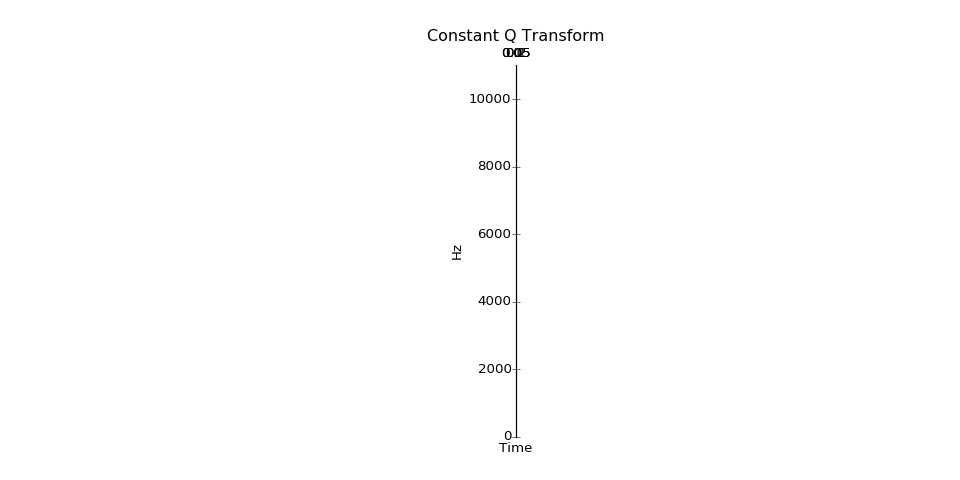

In [161]:
plt.matshow(np.abs(frame_wvd), 
            origin="lower", 
            aspect=1.0, 
            interpolation="bicubic")
plt.show()

<IPython.core.display.Javascript object>


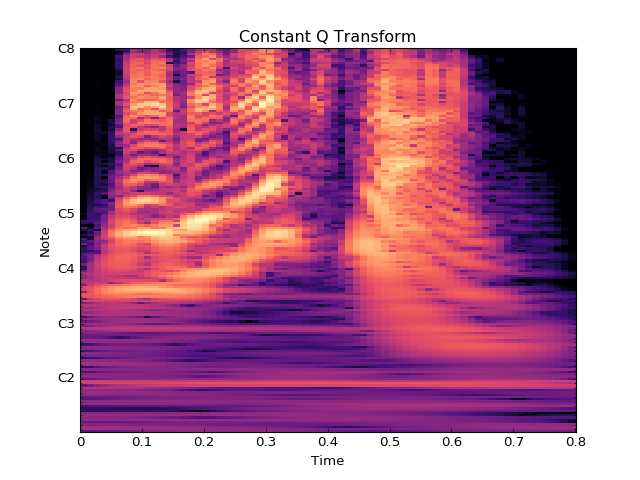

In [185]:
bins_per_octave = 24
voice_cqt = lr.core.cqt(voice, 
                        sr=sr, 
                        n_bins=7*bins_per_octave, 
                        bins_per_octave=bins_per_octave,
                        filter_scale=1.0,
                        tuning=0., 
                        window='hann')

lr.display.specshow(lr.amplitude_to_db(np.abs(voice_cqt),
                                       ref=np.max),
                    y_axis='cqt_note', x_axis='time', hop_length=512, sr=sr, bins_per_octave=bins_per_octave)
plt.title('Constant Q Transform')
plt.show()

In [331]:
bins_per_octave = 12
voice_cqt_dt = lr.core.cqt(voice, 
                           sr=sr, 
                           n_bins=4*bins_per_octave, 
                           bins_per_octave=bins_per_octave,
                           filter_scale=1.0,
                           tuning=0., 
                           window='hann')

lr.display.specshow(np.abs(voice_cqt_dt),
                    y_axis='cqt_note', x_axis='time', hop_length=512, sr=sr, bins_per_octave=bins_per_octave)
plt.title('Constant Q Transform dt')
plt.show()

In [1234]:
def hann_t(n):
    '''
    time weighed hann window
    '''
    x = np.linspace(-1, 1, n, endpoint=False)
    return x * (np.cos(np.pi * x)*0.5 + 0.5)

def hann_dt(n):
    '''
    time derivative of the hann window
    '''
    x = np.linspace(0, 2, n, endpoint=False)
    return 0.5 * np.sin(np.pi * x)

window_plot = figure()
window_length = 64
window_x = np.linspace(0, window_length, window_length)
window = lr.filters.get_window('hann', window_length)
window_plot.line(window_x, window)
window_plot.line(window_x, hann_t(window_length))
window_plot.line(window_x, hann_dt(window_length))
show(window_plot)

In [1024]:
def gaussian(n, std=0.1):
    g = signal.gaussian(n, std*n)
    return g

def hann_t(n, std=0.1):
    '''
    time weighed hann window
    '''
    x = np.linspace(-1, 1, n, endpoint=False)
    return x * (np.cos(np.pi * x)*0.5 + 0.5)

def hann_dt(n):
    '''
    time derivative of the hann window
    '''
    x = np.linspace(0, 2, n, endpoint=False)
    return 0.5 * np.sin(np.pi * x)

window_plot = figure()
window_length = 128
window_x = np.linspace(0, window_length, window_length)
window = gaussian(window_length)
window_plot.line(window_x, window)
window_plot.line(window_x, hann_t(window_length))
window_plot.line(window_x, hann_dt(window_length))
show(window_plot)

AttributeError: 'numpy.ndarray' object has no attribute 'gaussian'

<IPython.core.display.Javascript object>


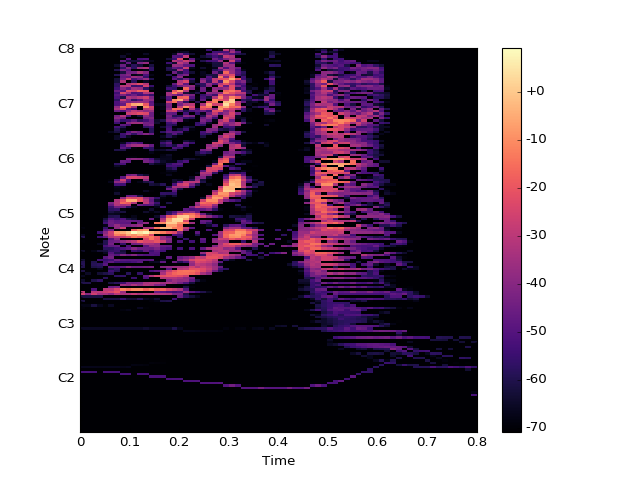

In [439]:
bins_per_octave=24
hop_length=512
filter_scale = 2.
def cqt_reassignment(x, 
                     sr=22050, 
                     hop_length=512, 
                     fmin=lr.note_to_hz('C1'), 
                     n_bins=84, 
                     bins_per_octave=12, 
                     tuning=0.0, 
                     filter_scale=1):
    
    cqt = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                      bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                      window='hann', scale=True)
    
    cqt_t = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                        bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                        window=hann_t, scale=True)
    
    cqt_dt = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                         bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                         window=hann_dt, scale=True)
    
    time_steps = cqt.shape[1]
    
    frequencies = lr.core.cqt_frequencies(n_bins, fmin, bins_per_octave, tuning)
    
    cqt_sq = np.abs(cqt)**2
    
    frequency_shift_factor = 400. * filter_scale * bins_per_octave / (2**(np.linspace(0, n_bins/bins_per_octave, frequencies.shape[0])) * hop_length)
    frequency_shifts = np.imag(cqt_dt * np.conj(cqt)) / cqt_sq
    frequency_shifts = np.nan_to_num(frequency_shifts) * frequency_shift_factor.reshape(-1, 1)
    
    # Why 144?
    time_shift_factor = 144. * filter_scale * bins_per_octave / (2**(np.linspace(0, n_bins/bins_per_octave, frequencies.shape[0])) * hop_length)
    time_shifts = np.real(cqt_t * np.conj(cqt)) / cqt_sq
    time_shifts = np.nan_to_num(time_shifts) * time_shift_factor.reshape(-1, 1)
    
    reassigned_cqt = np.zeros([n_bins, time_steps])
    oct_min = lr.hz_to_octs(fmin)
    
    for b in range(n_bins):
        for t in range(time_steps):
            f_bin = b
            t_bin = t
            if cqt_sq[b, t] > 0.000001:
                freq = frequencies[b] + frequency_shifts[b, t]
                freq = max(freq, fmin)
                f_bin = math.floor((lr.hz_to_octs(freq) - oct_min) * bins_per_octave + 0.5)
                f_bin = min(max(f_bin, 0), n_bins-1)
                t_bin = math.floor(t + time_shifts[b, t] + 0.5)
                t_bin = min(max(t_bin, 0), time_steps-1)
            else:
                frequency_shifts[b, t] = 0
                time_shifts[b, t] = 0
                f_bin = b
                t_bin = t

            reassigned_cqt[f_bin, t_bin] += cqt_sq[b, t] 
            
    return reassigned_cqt, frequency_shifts, time_shifts, cqt, cqt_t, cqt_dt
    
reassigned_cqt, frequency_shifts, time_shifts, cqt, cqt_t, cqt_dt = cqt_reassignment(voice, 
                                                                                     sr=sr, 
                                                                                     n_bins=7*bins_per_octave, 
                                                                                     bins_per_octave=bins_per_octave,
                                                                                     filter_scale=filter_scale, 
                                                                                     hop_length=hop_length)   

lr.display.specshow(lr.amplitude_to_db(reassigned_cqt),
                    y_axis='cqt_note', x_axis='time', hop_length=512, sr=sr, bins_per_octave=bins_per_octave)
plt.colorbar(format='%+2.0f')
plt.show()

<IPython.core.display.Javascript object>


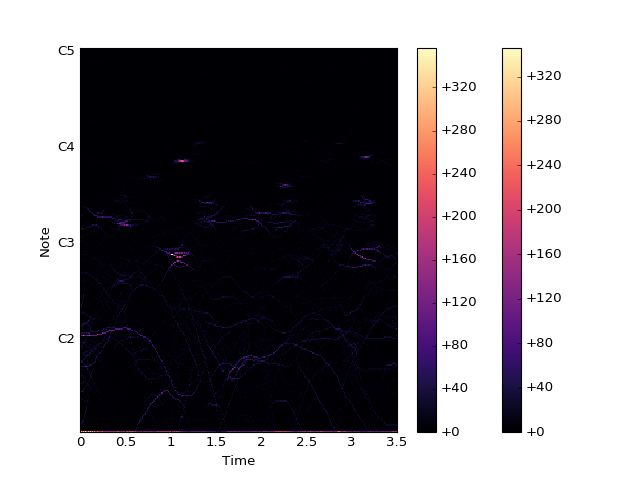

In [418]:
x_ref = np.arange(time_shifts.shape[1])
plt.plot(frequency_shifts[:, 50])
plt.plot(frequency_shifts[:, 100])
plt.plot(frequency_shifts[:, 150])
plt.plot(frequency_shifts[:, 200])
plt.plot(frequency_shifts[:, 270])
#plt.plot(time_shifts[140, :])
#plt.plot(time_shifts[190, :])
plt.show()

q: 51.43862596945148
hop_frequency:  86.1328125


<IPython.core.display.Javascript object>


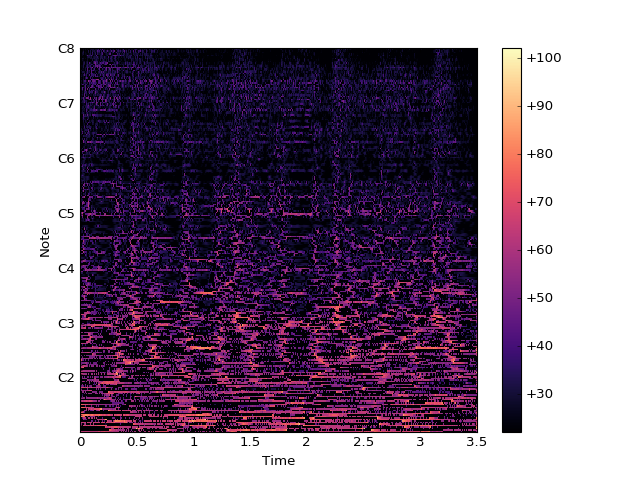

In [1305]:
length = 20000
freq = 217.
sr=44100
signal_x = np.linspace(0, 2*freq*np.pi * (length/sr), length) ** 1.0
signal = (np.cos(signal_x) + np.sin(signal_x*3.) + np.sin(signal_x*12.)) * lr.filters.get_window('hann', length) * 0.1
#signal[5000] = 0.9
signal[5000:5020] += 0.5

bins_per_octave=36
octaves = 7
fmin = 40.
hop_length=128
filter_scale = 1.0
def cqt_reassignment(x, 
                     sr=22050, 
                     hop_length=512, 
                     fmin=lr.note_to_hz('C1'), 
                     n_bins=84, 
                     bins_per_octave=12, 
                     tuning=0.0, 
                     filter_scale=1):
    
    frequencies = lr.core.cqt_frequencies(n_bins, fmin, bins_per_octave, tuning)
    filter_lengths = lr.filters.constant_q_lengths(sr, fmin, n_bins, bins_per_octave, tuning, 'hann', filter_scale).reshape(-1, 1)
    #print("filter lengths:", filter_lengths)
    #print("frequencies: ", frequencies)
    q = float(filter_scale) / (2.0**(1. / bins_per_octave) - 1)
    print("q:", q)
    hop_frequency = sr / hop_size
    print("hop_frequency: ", hop_frequency)
    
    
    #basis, lengths = lr.filters.constant_q(sr,
    #                                    fmin=fmin,
    #                                    n_bins=n_bins,
    #                                    bins_per_octave=bins_per_octave,
    #                                    tuning=tuning,
    #                                    filter_scale=filter_scale,
    #                                    norm=np.inf,
    #                                    pad_fft=True,
    #                                    window=hann_t)
    
    scaling = (1/filter_lengths**0.5)
    #print("scaling:", scaling)
    scaling = scaling.reshape(-1,1)
    
    #print("basis:", basis.shape)
    #print("lengths: ", lengths)
    
    cqt = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                      bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                      window='hann', scale=False, norm=np.inf) * scaling
    
    cqt_t = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                        bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                        window=hann_t, scale=False, norm=np.inf) * scaling
    #cqt_t_factor = 0.131 * (filter_lengths / hop_length)
    #cqt_t = cqt_t * cqt_t_factor.reshape(-1, 1)
    
    cqt_dt = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                         bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                         window=hann_dt, scale=False, norm=np.inf) * scaling
    #cqt_dt_factor = 0.023 * frequencies
    #cqt_dt = cqt_dt * cqt_dt_factor.reshape(-1, 1)
    
    time_steps = cqt.shape[1]
    
    cqt_abs = np.abs(cqt)
    cqt_sq = cqt_abs**2
    
    frequency_shifts =  np.imag(cqt_dt * np.conj(cqt)) / (filter_lengths * cqt_sq)
    frequency_shifts = np.nan_to_num(frequency_shifts) * sr * 0.5 
    
    time_shifts = np.real(filter_lengths * cqt_t * np.conj(cqt) / cqt_sq)
    time_shifts = np.nan_to_num(time_shifts) / hop_length * 0.131 
    
    reassigned_cqt = np.zeros([n_bins, time_steps])
    oct_min = lr.hz_to_octs(fmin)
    
    for b in range(n_bins):
        for t in range(time_steps):
            f_bin = b
            t_bin = t
            if cqt_sq[b, t] > 2000.:
                freq = frequencies[b] + frequency_shifts[b, t]
                freq = max(freq, fmin)
                f_bin = math.floor((lr.hz_to_octs(freq) - oct_min) * bins_per_octave + 0.5)
                f_bin = min(max(f_bin, 0), n_bins-1)
                #print("freq: " + str(frequencies[b]) + 
                #      ", freq_shift: " + str(frequency_shifts[b, t]) + 
                #      ", f_bin: " + str(f_bin))
                
                t_bin = math.floor(t + time_shifts[b, t] + 0.5)
                t_bin = min(max(t_bin, 0), time_steps-1)
            else:
                frequency_shifts[b, t] = 0
                time_shifts[b, t] = 0
                f_bin = b
                t_bin = t
            #f_bin = b
            #t_bin = t

            reassigned_cqt[f_bin, t_bin] += cqt_abs[b, t] 
            
    return reassigned_cqt, frequency_shifts, time_shifts, cqt, cqt_t, cqt_dt, basis

voice_n = voice.copy()
voice_n[30000:30050] += 1. 
reassigned_cqt, frequency_shifts, time_shifts, cqt, cqt_t, cqt_dt, basis = cqt_reassignment(voice, 
                                                                                     sr=sr, 
                                                                                     n_bins=octaves*bins_per_octave, 
                                                                                     bins_per_octave=bins_per_octave,
                                                                                     filter_scale=filter_scale, 
                                                                                     hop_length=hop_length,
                                                                                     fmin=fmin)   

lr.display.specshow(lr.amplitude_to_db(reassigned_cqt),
                    y_axis='cqt_note', x_axis='time', hop_length=hop_length, sr=sr, bins_per_octave=bins_per_octave)
plt.colorbar(format='%+2.0f')
plt.show()

<IPython.core.display.Javascript object>


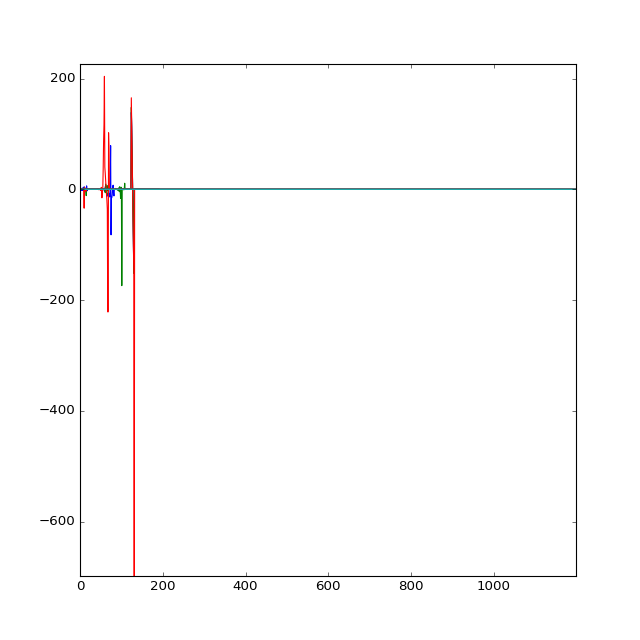

In [985]:
plt.figure(figsize=[8, 8])

x_ref = np.arange(time_shifts.shape[1])
plt.plot(frequency_shifts[:, 20])
plt.plot(frequency_shifts[:, 50])
plt.plot(frequency_shifts[:, 70])
#plt.plot(time_shifts[:, 5])
#plt.plot(time_shifts[:, 10])
#plt.plot(time_shifts[:, 15])

#plt.xlim(0, 70)
#plt.ylim(-35, 35)
plt.show()

In [ ]:
time reassignment independent of q! 
independent of sr!
umgekehrt proportional zu hop_length!

freq reassignment proportional to sr!

<IPython.core.display.Javascript object>


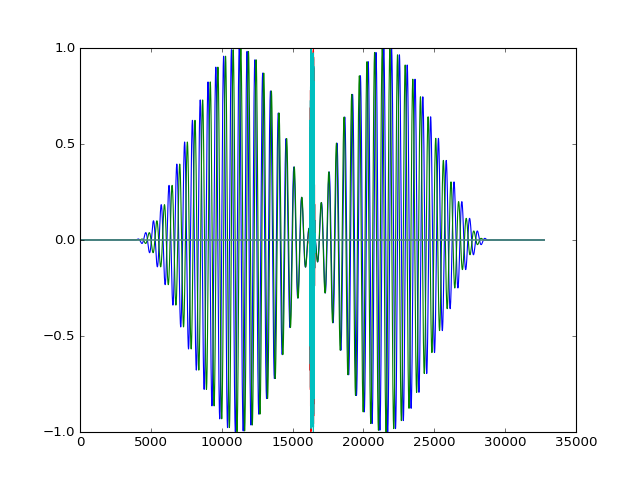

In [998]:
plt.plot(np.real(basis[0, :]))
plt.plot(np.real(basis[1, :]))
plt.plot(np.real(basis[-2, :]))
plt.plot(np.real(basis[-1, :]))
plt.show()

bins_per_octave: 48 -> f=0.28
bins_per_octave: 24 -> f=0.28
bins_per_octave: 12 -> f=0.28
bins_per_octave: linear!!

filter_scale: 1.0 -> f=13.44
filter_scale: 0.5 -> f=13.44
filter_scale: 2.0 -> f=13.44
filter_scale: linear!!

hop_length: 1024 -> f=0.00625
hop_length: 512 -> f=0.026
hop_length: 256 -> f=0.1
hop_length: 128 -> f=0.4
hop_length: 1/hop_length^2 

fmin: 21.533203125


<IPython.core.display.Javascript object>


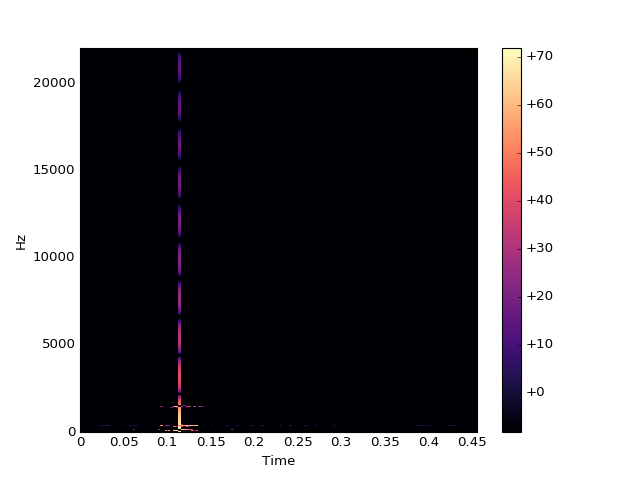

In [923]:
# length = 20000
# freq = 3100.
# sr=44100
# signal_x = np.linspace(0, 2*freq*np.pi * (length/sr), length) ** 1.0
# signal = (np.cos(signal_x) + np.sin(signal_x*1.4) + np.sin(signal_x*2)) * lr.filters.get_window('hann', length) * 0.1
# signal[10000:10010] += 1.

def stft_reassignment(x, n_fft, hop_length=None, sr=22050):
    stft = lr.core.stft(x, n_fft, hop_length, window='hann')
    stft_sq = np.abs(stft)**2
    stft_t = lr.core.stft(x, n_fft, hop_length, window=hann_t)
    stft_dt = lr.core.stft(x, n_fft, hop_length, window=hann_dt)
    
    frequencies = lr.core.fft_frequencies(sr=sr, n_fft=n_fft)
    fmin = frequencies[1]
    print("fmin:", fmin)
    
    frequency_shifts = np.imag(stft_dt * np.conj(stft)) / stft_sq
    frequency_shifts = np.nan_to_num(frequency_shifts) * fmin
    
    time_shifts = np.real(stft_t * np.conj(stft)) / stft_sq
    time_shifts = np.nan_to_num(time_shifts) * (n_fft / hop_length) * 0.5
    
    n_bins = stft.shape[0]
    time_steps = stft.shape[1]
    reassigned_stft = np.zeros([n_bins, time_steps])
    
    for b in range(n_bins):
        for t in range(time_steps):
            f_bin = b
            t_bin = t
            if stft_sq[b, t] > 0.01:
                freq = frequencies[b] + frequency_shifts[b, t]
                f_bin = math.floor(freq / fmin + 0.5)
                f_bin = min(max(f_bin, 0), n_bins-1)
                #print("freq: " + str(frequencies[b]) + 
                #      ", freq_shift: " + str(frequency_shifts[b, t]) + 
                #      ", f_bin: " + str(f_bin))
                
                t_bin = math.floor(t + time_shifts[b, t] + 0.5)
                t_bin = min(max(t_bin, 0), time_steps-1)
            else:
                frequency_shifts[b, t] = 0
                time_shifts[b, t] = 0
                f_bin = b
                t_bin = t
            #f_bin = b
            #t_bin = t

            reassigned_stft[f_bin, t_bin] += stft_sq[b, t] 
    return reassigned_stft, frequency_shifts, time_shifts

n_fft = 2048
hop_length = 128
reassigned_stft, frequency_shifts, time_shifts = stft_reassignment(signal, n_fft, hop_length=hop_length, sr=sr)

lr.display.specshow(lr.amplitude_to_db(reassigned_stft),
                    y_axis='linear', x_axis='time', hop_length=hop_length, sr=sr)
plt.colorbar(format='%+2.0f')
plt.show()

<IPython.core.display.Javascript object>


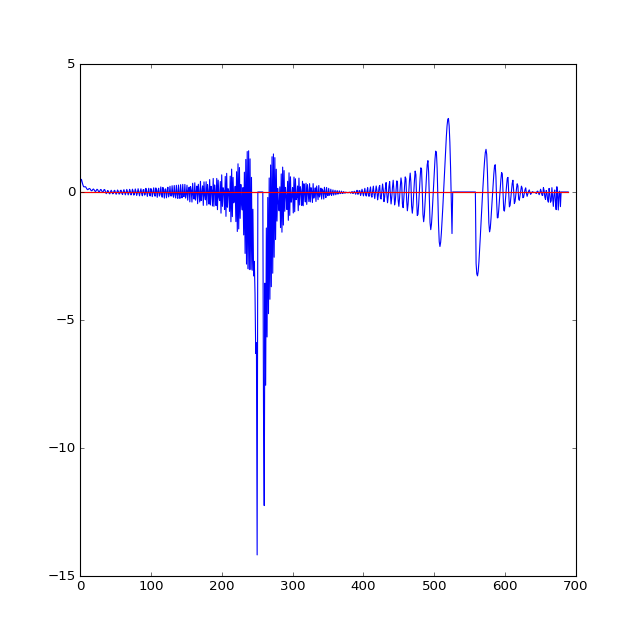

In [821]:
plt.figure(figsize=[8, 8])

x_ref = np.arange(time_shifts.shape[1])
plt.plot(time_shifts[1, :])
plt.plot(time_shifts[10, :])
plt.plot(time_shifts[50, :])

In [14]:
N = 4000
x = np.random.random(size=N) * 100
y = np.random.random(size=N) * 100
radii = np.random.random(size=N) * 1.5
colors = ["#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(np.floor(50+2*x), np.floor(30+2*y))]

In [15]:
p = figure()
p.circle(x, y, radius=radii, fill_color=colors, fill_alpha=0.6, line_color=None)

In [4]:
show(p)

some notes...

In [5]:
x = np.linspace(0, 10, 500)
sine_wave = np.sin(x)
p = figure()
# p.toolbar_location = None
p.line(x, sine_wave, line_width=3)
show(p)

In [6]:
%magic

In [7]:
l = 512
x = np.linspace(0, 1, l)
window = np.hanning(l)

p = figure()
p.line(x, window, line_width=3)
show(p)

In [8]:
l = 512
x = np.linspace(0, 1, l)
sine_wave = np.sin(x)

In [9]:
p = figure(title="sine plot", plot_height=300, plot_width=600, y_range=(-1.2,1.2))
r = p.line(x=x, y=sine_wave, color="#2222aa", line_width=3)
show(p)

In [10]:
def update(freq=1., phi=0):
    r.data_source.data['y'] = np.sin(freq * 2 * np.pi * x + phi)
    push_notebook()

In [11]:
show(p, notebook_handle=True)

In [12]:
interact(update, freq=(0., 20., 0.1), phi=(0, 6.28, 0.1))

In [13]:
conv_plot = figure(title="convolution", plot_height=300, plot_width=600, y_range=(-1.2,1.2))

l = 512
x = np.linspace(0, 1, l)
patch_x = np.concatenate([[0], x, [1]])
window = np.hanning(l)
window_tw = window + x - 0.5
window_td = np.diff(np.concatenate([[0], window])) * l

sig_freq = 4.
signal = np.sin(sig_freq * 2 * np.pi* x)
analysis = window
signal_line = conv_plot.line(x=x, y=signal, color="#448844", line_width=3)
analysis_line = conv_plot.line(x=x, y=analysis, color="#bb2222", line_width=3)
product = np.concatenate([[0], signal*analysis, [0]])
product_line = conv_plot.patch(x=patch_x, y=product, color="#bb2222", alpha=0.5, line_width=None)

def update_analysis_function(freq=4., phi=0.):
    print("change plot")
    f = np.sin(freq * 2 * np.pi * x + phi) * window
    analysis_line.data_source.data['y'] = f
    product = np.concatenate([[0], f * signal, [0]])
    product_line.data_source.data['y'] = product
    push_notebook()

In [14]:
show(conv_plot, notebook_handle=True)

In [15]:
interact(update_analysis_function, freq=(0., 10., 0.1), phi=(0, 6.28, 0.1))

change plot


In [23]:
l = 512
x = np.linspace(0, 1, l)
patch_x = np.concatenate([[0], x, [1]])
window = np.hanning(l)
window = np.concatenate([[0], np.linspace(0, 1, l//2 - 1), np.linspace(1, 0, l//2 - 1), [0]])
window_tw = window + x - 0.5
window_td = np.diff(np.concatenate([[0], window])) * l / 4.
analysis_freq = 6.

regular_plot = figure(title="regular window", plot_height=300, plot_width=500, y_range=(-1.2,1.2))
regular_prod_plot = figure(plot_height=300, plot_width=500, y_range=(-1.2,1.2))
deriv_plot = figure(title="time derivative window", plot_height=300, plot_width=500, y_range=(-1.2,1.2))
deriv_prod_plot = figure(plot_height=300, plot_width=500, y_range=(-1.2,1.2))
grid = gridplot([[regular_plot, deriv_plot], [regular_prod_plot, deriv_prod_plot]])

real_analysis = np.cos(analysis_freq * 2 * np.pi * x) * window
imag_analysis = np.sin(analysis_freq * 2 * np.pi * x) * window
td_real_analysis = np.cos(analysis_freq * 2 * np.pi * x) * window_td
td_imag_analysis = np.sin(analysis_freq * 2 * np.pi * x) * window_td

signal_plot = regular_plot.line(x=x, y=x, color="#aaaaaa", line_width=4)
real_analysis_plot = regular_plot.line(x=x, y=real_analysis, color="#2222aa", line_width=2)
imag_analysis_plot = regular_plot.line(x=x, y=imag_analysis, color="#aa2222", line_width=2)
real_product_plot = regular_prod_plot.patch(x=patch_x, y=patch_x, color="#2222aa", alpha=0.5) 
imag_product_plot = regular_prod_plot.patch(x=patch_x, y=patch_x, color="#aa2222", alpha=0.5) 
real_sum_plot = regular_prod_plot.circle(x=[1.], y=[0.], color="#2222aa", radius=0.008)
imag_sum_plot = regular_prod_plot.circle(x=[1.], y=[0.], color="#aa2222", radius=0.008)

td_signal_plot = deriv_plot.line(x=x, y=x, color="#aaaaaa", line_width=4)
td_real_analysis_plot = deriv_plot.line(x=x, y=td_real_analysis, color="#2222aa", line_width=2)
td_imag_analysis_plot = deriv_plot.line(x=x, y=td_imag_analysis, color="#aa2222", line_width=2)
td_real_product_plot = deriv_prod_plot.patch(x=patch_x, y=patch_x, color="#2222aa", alpha=0.5) 
td_imag_product_plot = deriv_prod_plot.patch(x=patch_x, y=patch_x, color="#aa2222", alpha=0.5) 
td_real_sum_plot = deriv_prod_plot.circle(x=[1.], y=[0.], color="#2222aa", radius=0.008)
td_imag_sum_plot = deriv_prod_plot.circle(x=[1.], y=[0.], color="#aa2222", radius=0.008)

def update_reassignment_plot(freq=6., phi=0.):
    sig = np.cos(freq * 2 * np.pi * x + phi)
    
    real_prod = sig * real_analysis
    imag_prod = sig * imag_analysis
    real_sum = np.sum(real_prod) / l
    imag_sum = np.sum(imag_prod) / l
    
    signal_plot.data_source.data['y'] = sig
    real_product_plot.data_source.data['y'] = real_prod
    imag_product_plot.data_source.data['y'] = imag_prod
    real_sum_plot.data_source.data['y'] = [real_sum]
    imag_sum_plot.data_source.data['y'] = [imag_sum]
    
    td_real_prod = sig * td_real_analysis
    td_imag_prod = sig * td_imag_analysis
    td_real_sum = np.sum(td_real_prod) / l
    td_imag_sum = np.sum(td_imag_prod) / l
    
    td_signal_plot.data_source.data['y'] = sig
    td_real_product_plot.data_source.data['y'] = td_real_prod
    td_imag_product_plot.data_source.data['y'] = td_imag_prod
    td_real_sum_plot.data_source.data['y'] = [td_real_sum]
    td_imag_sum_plot.data_source.data['y'] = [td_imag_sum]
    
    push_notebook()    

In [24]:
show(grid, notebook_handle=True)
#show(regular_prod_plot, notebook_handle=True)

In [25]:
interact(update_reassignment_plot, freq=(0., 10., 0.1), phi=(0, 6.28, 0.1))

In [95]:
voice_clip, _= lr.load("voice.wav", sr=44100)
print(voice_clip)

[ 0.  0.  0. ...,  0.  0.  0.]


In [99]:
display.Audio(data=voice_clip, rate=44100)

In [103]:
stft_amp = np.abs(lr.core.stft(voice_clip))
print(stft_amp)

[[  0.00000000e+00   1.55028766e-02   6.25764057e-02 ...,   4.84885946e-02
    2.61166040e-03   8.44684709e-03]
 [  0.00000000e+00   2.09291689e-02   1.02055661e-01 ...,   5.85813634e-02
    1.56608745e-02   8.27138778e-03]
 [  0.00000000e+00   3.00869532e-02   1.54616535e-01 ...,   6.88507855e-02
    7.54684256e-03   8.27720016e-03]
 ..., 
 [  0.00000000e+00   2.13309380e-04   4.20754484e-04 ...,   1.25315375e-04
    1.38443356e-04   3.41425824e-04]
 [  0.00000000e+00   2.13960258e-04   4.06418811e-04 ...,   1.45175771e-04
    2.88740441e-04   3.35486460e-04]
 [  0.00000000e+00   2.14588901e-04   4.46831429e-04 ...,   1.52420849e-04
    1.88891179e-04   3.42786981e-04]]


In [108]:
spect_plot = figure(x_range=(0, 10), y_range=(0, 3))
spect_plot.image(image=[stft_amp], x=0, y=0, dw=10, dh=10, palette="Spectral11")

In [109]:
show(spect_plot)

In [35]:
l = 16
x_ramp = np.linspace(0, 1, num=l, endpoint=False)
print(x_ramp)
harmonics = np.zeros([l, l])
for i in range(l):
    harmonics[i, :] = np.cos(x_ramp * np.pi * (i+1))
    
fourier_plot = figure(x_range=(0, l), y_range=(0, l))
fourier_plot.image(image=[harmonics], x=0, y=0, dw=l, dh=l, palette="Magma256")

show(fourier_plot)

[ 0.      0.0625  0.125   0.1875  0.25    0.3125  0.375   0.4375  0.5
  0.5625  0.625   0.6875  0.75    0.8125  0.875   0.9375]
